# Data Creation

This notebook contains processing code to construct our final dataframe and provides interesting statistics about the state of the data along the way.

In [3]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load all trip data and concatenate in same dataframe
csv_files = glob.glob('data/raw/2023*-capitalbikeshare-tripdata.csv')
df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

ValueError: No objects to concatenate

In [ ]:
# number of trips, for reporting purposses
len(df)

4467334

In [ ]:
df = df[
    df['start_station_name'].notna() &
    (df['start_station_name'].str.strip() != '') &
    df['end_station_name'].notna() &
    (df['end_station_name'].str.strip() != '')
]

In [ ]:
# number of trips starting and ending at stations, for reporting purposses
len(df)

3864783

In [ ]:
print("Unique start stations:", len(df["start_station_name"].unique()))
print("Unique end stations:", len(df["end_station_name"].unique()))

Unique start stations: 793
Unique end stations: 797


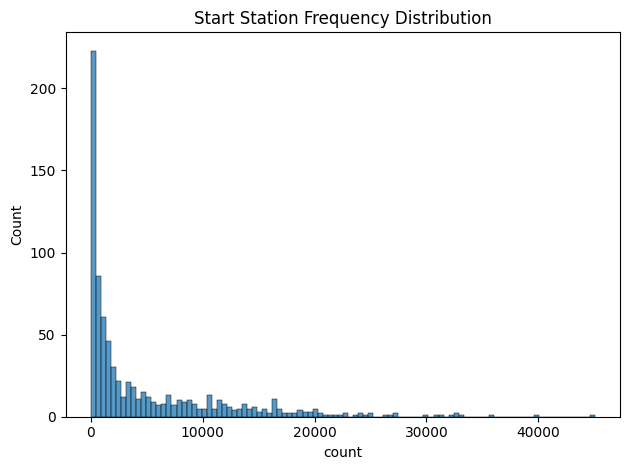

In [ ]:
station_counts = df["start_station_name"].value_counts()
sns.histplot(data=station_counts, bins=100)
plt.title('Start Station Frequency Distribution')
plt.tight_layout()
plt.savefig('figures/start_station_distribution_before.png')
plt.show()

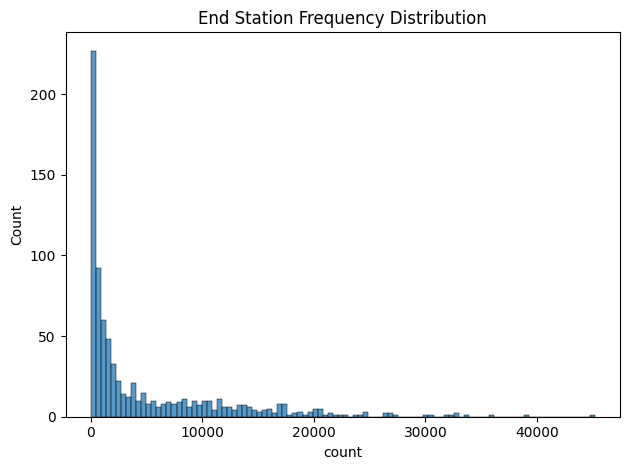

In [ ]:
station_counts = df["end_station_name"].value_counts()
sns.histplot(data=station_counts, bins=100)
plt.title('End Station Frequency Distribution')
plt.tight_layout()
plt.savefig('figures/end_station_distribution_before.png')
plt.show()

In [ ]:
station_data = pd.read_csv("data/raw/Capital_Bikeshare_Locations.csv")
# Match trips and stations so that only trips starting and ending in **still active stations** are kept
matched_df = df[df['start_station_name'].isin(station_data['NAME']) &
                df['end_station_name'].isin(station_data['NAME'])].copy()
print(len(matched_df))

3632735


In [ ]:
len(station_data)

786

In [ ]:
print("Unique start stations:", len(matched_df["start_station_name"].unique()))
print("Unique end stations:", len(matched_df["end_station_name"].unique()))

Unique start stations: 738
Unique end stations: 738


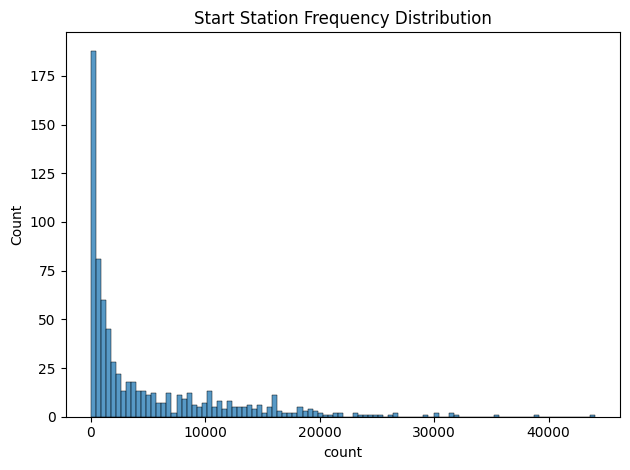

In [ ]:
station_counts = matched_df["start_station_name"].value_counts()
sns.histplot(data=station_counts, bins=100)
plt.title('Start Station Frequency Distribution')
plt.tight_layout()
plt.savefig('figures/start_station_distribution_after.png')
plt.show()

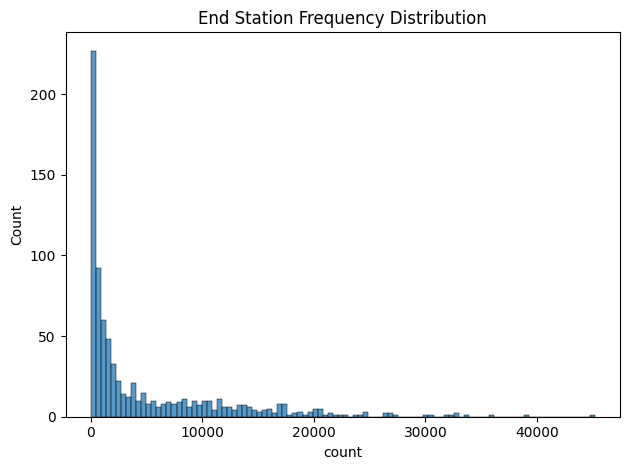

In [ ]:
station_counts = df["end_station_name"].value_counts()
sns.histplot(data=station_counts, bins=100)
plt.title('End Station Frequency Distribution')
plt.tight_layout()
plt.savefig('figures/end_station_distribution_after.png')
plt.show()

In [ ]:
# Convert start/end times into start/end hours 
matched_df['started_at'] = pd.to_datetime(matched_df['started_at'])
matched_df['ended_at'] = pd.to_datetime(matched_df['ended_at'])

matched_df['start_hour'] = matched_df['started_at'].dt.floor('h')
matched_df['end_hour'] = matched_df['ended_at'].dt.floor('h')

In [ ]:
# Calculate number of arrivals/departures from/to station per respective hour
departures = matched_df.groupby(['start_station_name', 'start_hour']).size().reset_index(name='departures')
departures.rename(columns={'start_station_name': 'station_name', 'start_hour': 'hour'}, inplace=True)

arrivals = matched_df.groupby(['end_station_name', 'end_hour']).size().reset_index(name='arrivals')
arrivals.rename(columns={'end_station_name': 'station_name', 'end_hour': 'hour'}, inplace=True)

In [ ]:
# merge departures and arrivals
station_hourly = pd.merge(departures, arrivals, on=['station_name', 'hour'], how='outer').fillna(0)

# ensure that we have all hours from beginning to end of time period covered in the data
full_time_index = pd.date_range(start=station_hourly['hour'].min(), end=station_hourly['hour'].max(), freq='h')
stations = station_hourly['station_name'].unique()
full_index = pd.MultiIndex.from_product([stations, full_time_index], names=['station_name', 'hour'])
station_hourly = station_hourly.set_index(['station_name', 'hour']).reindex(full_index)
station_hourly['departures'] = station_hourly['departures'].fillna(0)
station_hourly['arrivals'] = station_hourly['arrivals'].fillna(0)
station_hourly = station_hourly.reset_index()

In [5]:
hourly_weather = pd.read_parquet("data/processed/weather_hourly_all_locations_2023.parquet")

In [6]:
hourly_weather["date"] = pd.to_datetime(hourly_weather["date"], utc=True) - pd.Timedelta(hours=4)

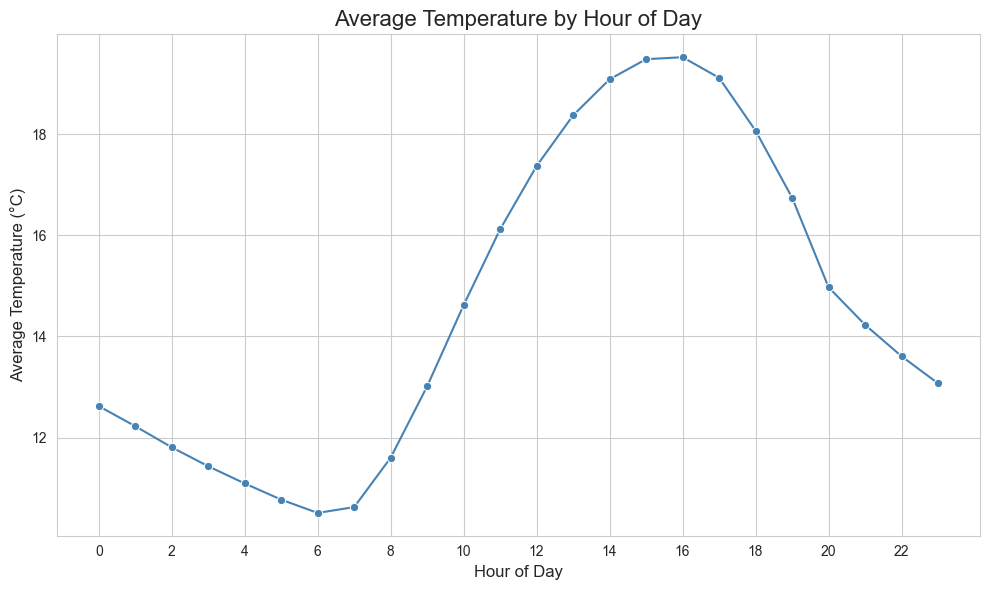

In [ ]:
hourly_avg_temps = hourly_weather.copy()
hourly_avg_temps['hour_of_day'] = hourly_avg_temps['date'].dt.hour
avg_temp_by_hour = hourly_avg_temps.groupby('hour_of_day')['temperature_2m'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

ax = sns.lineplot(x="hour_of_day", y="temperature_2m", data=avg_temp_by_hour, color='steelblue')
plt.title('Average Temperature by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Temperature (°C)', fontsize=12)
plt.xticks(range(0, 24, 2))
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/avg_temperature_by_hour.png')
plt.show()

In [7]:
# Add station name to weather
merged_df = pd.merge(hourly_weather, station_data[['LATITUDE', 'LONGITUDE', 'NAME']],
                     left_on=['latitude', 'longitude'], right_on=['LATITUDE', 'LONGITUDE'], how='inner')


NameError: name 'station_data' is not defined

In [ ]:
# This seems useless, but is important for the below join to work!
station_hourly["hour"] = pd.to_datetime(station_hourly["hour"],utc=True)


Quick sanity check about how the timedata for trips works:

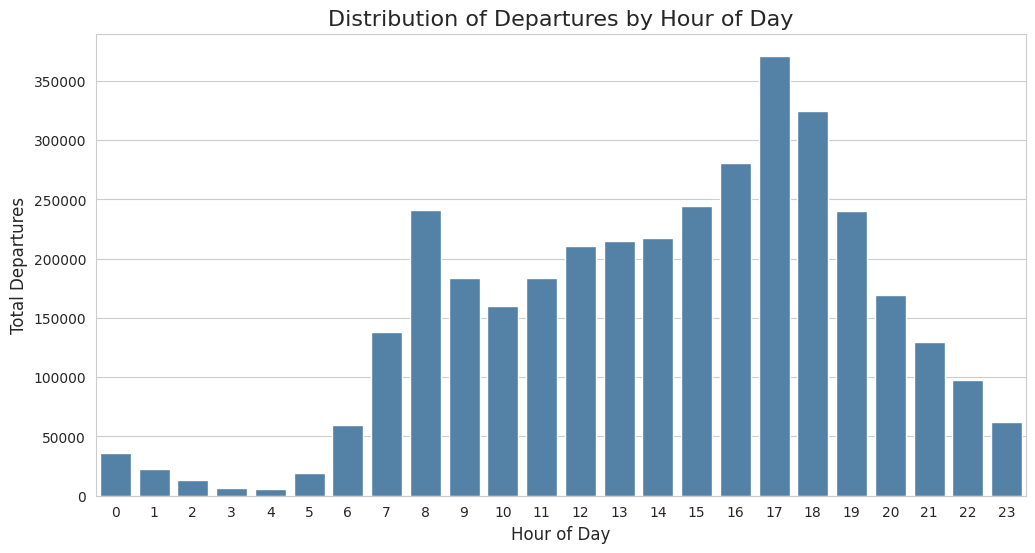

In [23]:
station_hourly['hour_extract'] = station_hourly['hour'].dt.hour

hourly_totals = station_hourly.groupby("hour_extract")["departures"].sum().reset_index()
hourly_totals = hourly_totals.sort_values(by="hour_extract")

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
    
ax = sns.barplot(x="hour_extract", y="departures", data=hourly_totals, color='steelblue')
plt.title('Distribution of Departures by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Total Departures', fontsize=12)
plt.savefig('figures/departures_by_time.png')
plt.show()

In [24]:
# Add hourly bike data to station name and weather
station_weather_data = pd.merge(station_hourly, merged_df,
                                left_on=["station_name", "hour"],
                                right_on=["NAME", "date"],
                                # important to left join here as we do not have weather data for the nights
                                # inner join would thus throw away 400 hours of activity at night time
                                how="left")

In [25]:
# Finally combine with the general data we have on the stations
combined_data_final = pd.merge(station_weather_data, station_data, left_on=["station_name"],
                                right_on=["NAME"], how="inner")

In [26]:
combined_data_final = combined_data_final.drop(columns=['date', "location_id", "latitude", "longitude", "LATITUDE_x", "LONGITUDE_x", 'NAME_x', "X", "Y", "NAME_y", "STATION_ID","GIS_LAST_MOD_DTTM", "OBJECTID", "STATION_STATUS", "EIGHTD_HAS_KEY_DISPENSER", "LAST_REPORTED","NUM_DOCKS_DISABLED", "NUM_BIKES_DISABLED", "IOS", "ANDROID", "ELECTRIC_BIKE_SURCHARGE_WAIVER", 'STATION_TYPE', 'IS_INSTALLED', 'IS_RETURNING', 'IS_RENTING', 'RENTAL_METHODS', 'REGION_ID', 'REGION_NAME', 'GIS_ID'])
combined_data_final.columns = combined_data_final.columns.str.lower()
combined_data_final = combined_data_final.rename(columns={
    'latitude_y': 'latitude',
    'longitude_y': 'longitude'
})


# New Features (Time Based)

In [27]:
df_full = combined_data_final

In [28]:
# Holiday
import holidays
hol = holidays.UnitedStates(years=2023)
holiday_dates = set(hol.keys())
df_full['isHoliday'] = df_full['hour'].dt.date.isin(holiday_dates)


In [29]:
# Weekdays
df_full['weekday'] = df_full['hour'].dt.weekday

In [30]:
# Night
df_full['night'] = df_full['hour'].dt.hour.apply(lambda h: h >= 21 or h < 6)

In [31]:
# Worktime
df_full['workhours'] = (
    df_full['hour'].dt.hour.between(8, 16) &
    df_full['weekday'].between(0, 4) &
    (~df_full['isHoliday'])
)

In [32]:
# Commute (2 hours before and after start and end of worktime)
df_full['commute'] = (
    df_full['hour'].dt.hour.between(6, 10) | df_full['hour'].dt.hour.between(15, 19) &
    df_full['weekday'].between(0, 4) &
    (~df_full['isHoliday'])
    )

In [33]:
df_full['free'] = (
    df_full['weekday'].between(5, 6) |
    df_full['isHoliday']
    )

In [34]:
df_full['day'] = df_full['hour'].dt.day
df_full['month'] = df_full['hour'].dt.month
df_full['year'] = df_full['hour'].dt.year
df_full['dayofweek'] = df_full['hour'].dt.dayofweek
df_full['dayofyear'] = df_full['hour'].dt.dayofyear
df_full["timestamp"] = df_full["hour"]
df_full['hour'] = df_full['hour'].dt.hour


# New Features (Station Based)

- pro Station: average delta / average arrivals / average depratures + für alles varianz/sd


In [35]:
df_full["delta"] = df_full["arrivals"] - df_full["departures"]

df_full['var_delta_station_total'] = (
    df_full
      .groupby('station_name')['delta']
      .transform('var')
)


In [36]:
df_full['avg_delta_station_total'] = (
    df_full
      .groupby('station_name')['delta']
      .transform('mean')
)

In [37]:
df_full['avg_arrivals_station_total'] = (
    df_full
      .groupby('station_name')['arrivals']
      .transform('mean')
)
df_full['avg_departures_station_total'] = (
    df_full
      .groupby('station_name')['departures']
      .transform('mean')
)
df_full['var_arrivals_station_total'] = (
    df_full
      .groupby('station_name')['arrivals']
      .transform('var')
)
df_full['var_departures_station_total'] = (
    df_full
      .groupby('station_name')['departures']
      .transform('var')
)

In [38]:
# nacht
night_stats = (
    df_full[df_full['night']]
      .groupby('station_name')['delta']
      .agg(avg_delta_station_night='mean', var_delta_station_night='var')
      .reset_index()
)

df_full = df_full.merge(night_stats, on='station_name', how='left')

night_stats = (
    df_full[df_full['night']]
      .groupby('station_name')['arrivals']
      .agg(avg_arrivals_station_night='mean', var_arrivals_station_night='var')
      .reset_index()
)

df_full = df_full.merge(night_stats, on='station_name', how='left')


night_stats = (
    df_full[df_full['night']]
      .groupby('station_name')['departures']
      .agg(avg_departures_station_night='mean', var_departures_station_night='var')
      .reset_index()
)

df_full = df_full.merge(night_stats, on='station_name', how='left')

In [39]:
# nicht nacht
night_stats = (
    df_full[df_full['night'] == False]
      .groupby('station_name')['delta']
      .agg(avg_delta_station_nonnight='mean', var_delta_station_nonnight='var')
      .reset_index()
)

df_full = df_full.merge(night_stats, on='station_name', how='left')

night_stats = (
    df_full[df_full['night'] == False]
      .groupby('station_name')['arrivals']
      .agg(avg_arrivals_station_nonnight='mean', var_arrivals_station_nonnight='var')
      .reset_index()
)

df_full = df_full.merge(night_stats, on='station_name', how='left')


night_stats = (
    df_full[df_full['night'] == False]
      .groupby('station_name')['departures']
      .agg(avg_departures_station_nonnight='mean', var_departures_station_nonnight='var')
      .reset_index()
)

df_full = df_full.merge(night_stats, on='station_name', how='left')

In [40]:
# feiertage
stats = (
    df_full[df_full['isHoliday']]
      .groupby('station_name')['delta']
      .agg(avg_delta_station_holiday='mean', var_delta_station_holiday='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

stats = (
    df_full[df_full['isHoliday']]
      .groupby('station_name')['arrivals']
      .agg(avg_arrivals_station_holiday='mean', var_arrivals_station_holiday='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')


stats = (
    df_full[df_full['isHoliday']]
      .groupby('station_name')['departures']
      .agg(avg_departures_station_holiday='mean', var_departures_station_holiday='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

In [41]:
# commute

stats = (
    df_full[df_full['commute']]
      .groupby('station_name')['delta']
      .agg(avg_delta_station_commute='mean', var_delta_station_commute='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

stats = (
    df_full[df_full['commute']]
      .groupby('station_name')['arrivals']
      .agg(avg_arrivals_station_commute='mean', var_arrivals_station_commute='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')


stats = (
    df_full[df_full['commute']]
      .groupby('station_name')['departures']
      .agg(avg_departures_station_commute='mean', var_departures_station_commute='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

In [42]:
# free

stats = (
    df_full[df_full['free']]
      .groupby('station_name')['delta']
      .agg(avg_delta_station_free='mean', var_delta_station_free='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

stats = (
    df_full[df_full['free']]
      .groupby('station_name')['arrivals']
      .agg(avg_arrivals_station_free='mean', var_arrivals_station_free='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')


stats = (
    df_full[df_full['free']]
      .groupby('station_name')['departures']
      .agg(avg_departures_station_free='mean', var_departures_station_free='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

In [43]:
# average delta für stunden mit niederschlag (precipitation > 0 oder windgeschwindigkeit über 10)?

mask = (df_full['precipitation'] > 0) | (df_full['wind_speed_10m'] > 15)

stats = (
    df_full[mask]
      .groupby('station_name')['delta']
      .agg(avg_delta_station_unfriendly_weather='mean', var_delta_station_unfriendly_weather='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

stats = (
    df_full[mask]
      .groupby('station_name')['arrivals']
      .agg(avg_arrivals_station_unfriendly_weather='mean', var_arrivals_station_unfriendly_weather='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')


stats = (
    df_full[mask]
      .groupby('station_name')['departures']
      .agg(avg_departures_station_unfriendly_weather='mean', var_departures_station_unfriendly_weather='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

In [44]:
df_full['sum'] = df_full["arrivals"] + df_full["departures"]

stats = (
    df_full
      .groupby('station_name')['sum']
      .agg(avg_sum_station='mean', var_sum_station='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

stats = (
    df_full[df_full['night']]
      .groupby('station_name')['sum']
      .agg(avg_sum_station_night='mean', var_sum_station_night='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

stats = (
    df_full[df_full['night'] == False]
      .groupby('station_name')['sum']
      .agg(avg_sum_station_nonnight='mean', var_sum_station_nonnight='var')
      .reset_index()
)
df_full = df_full.merge(stats, on='station_name', how='left')

stats = (
    df_full[df_full['isHoliday']]
      .groupby('station_name')['sum']
      .agg(avg_sum_station_holiday='mean', var_sum_station_holiday='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

stats = (
    df_full[df_full['commute']]
      .groupby('station_name')['sum']
      .agg(avg_sum_station_commute='mean', var_sum_station_commute='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

stats = (
    df_full[df_full['free']]
      .groupby('station_name')['sum']
      .agg(avg_sum_station_free='mean', var_sum_station_free='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')

mask = (df_full['precipitation'] > 0) | (df_full['wind_speed_10m'] > 15)

stats = (
    df_full[mask]
      .groupby('station_name')['sum']
      .agg(avg_sum_station_unfriendly_weather='mean', var_sum_station_unfriendly_weather='var')
      .reset_index()
)

df_full = df_full.merge(stats, on='station_name', how='left')


In [46]:
print(len(df_full))
df_full = df_full[df_full["timestamp"].dt.year == 2023]
print(len(df_full))

6476688
6464880


In [48]:
df_full.to_parquet("data/final/df.parquet", compression='brotli')